In [1]:
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
# Example dots
dots = [
    [0,1],
    [2,1],
    [3,7],
    [2,5],
    [1,8],
    [5,0],
    [6,7],
    [2,9],
    [4,4],
    [8,2],
    [5,1],
    [6,4],
    [2,5],
    [9,7],
]

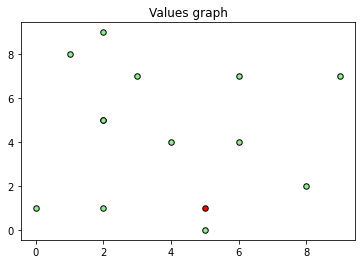

In [3]:
list_x = []
list_y = []

for i in range(len(dots)):
    if i == 10:
        plt.scatter([dots[i][0]],[dots[i][1]],
            marker='o',
            s=30,
            c='red',
            edgecolors='black')
        continue
    list_x.append(dots[i][0])
    list_y.append(dots[i][1])

plt.scatter(list_x,list_y,
           marker='o',
           s=30,
           c='lightgreen',
           edgecolors='black')

plt.title('Values graph')
plt.show()

In [4]:
# distance_matrix 계산하는 부분

sample = [0]*len(dots)
distance_matrix = []

for i in range(len(dots)):
    single_distance_matrix = []
    if i == 0:
        distance_matrix.append(sample)
        continue
        
    for j in range(len(dots)):
        distance = abs(dots[i][0] - dots[j][0]) + abs(dots[i][1] - dots[j][1])
        single_distance_matrix.append(distance)
    
    distance_matrix.append(single_distance_matrix)
    
distance_matrix
        

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 7, 4, 8, 4, 10, 8, 5, 7, 3, 7, 4, 13],
 [9, 7, 0, 3, 3, 9, 3, 3, 4, 10, 8, 6, 3, 6],
 [6, 4, 3, 0, 4, 8, 6, 4, 3, 9, 7, 5, 0, 9],
 [8, 8, 3, 4, 0, 12, 6, 2, 7, 13, 11, 9, 4, 9],
 [6, 4, 9, 8, 12, 0, 8, 12, 5, 5, 1, 5, 8, 11],
 [12, 10, 3, 6, 6, 8, 0, 6, 5, 7, 7, 3, 6, 3],
 [10, 8, 3, 4, 2, 12, 6, 0, 7, 13, 11, 9, 4, 9],
 [7, 5, 4, 3, 7, 5, 5, 7, 0, 6, 4, 2, 3, 8],
 [9, 7, 10, 9, 13, 5, 7, 13, 6, 0, 4, 4, 9, 6],
 [5, 3, 8, 7, 11, 1, 7, 11, 4, 4, 0, 4, 7, 10],
 [9, 7, 6, 5, 9, 5, 3, 9, 2, 4, 4, 0, 5, 6],
 [6, 4, 3, 0, 4, 8, 6, 4, 3, 9, 7, 5, 0, 9],
 [15, 13, 6, 9, 9, 11, 3, 9, 8, 6, 10, 6, 9, 0]]

In [5]:
# time window 계산
time_window = [
    (0, 100),
    (0, 100),
    (0, 100),
    (0, 100),
    (10, 100),
    (0, 100),
    (10, 11),
    (0, 100),
    (0, 100),
    (0, 100),
    (40, 41),
    (0, 100),
    (0, 100),
    (0, 100),
]

time_window

[(0, 100),
 (0, 100),
 (0, 100),
 (0, 100),
 (10, 100),
 (0, 100),
 (10, 11),
 (0, 100),
 (0, 100),
 (0, 100),
 (40, 41),
 (0, 100),
 (0, 100),
 (0, 100)]

In [6]:
def create_data_model():
    data = {}
    data['time_matrix'] = distance_matrix
    data['time_windows'] = time_window
    data['num_vehicles'] = 3
    data['depot'] = 0
    return data

In [7]:
# Instance the data problem
data = create_data_model()

In [8]:
# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),data['num_vehicles'], data['depot'])

In [9]:
# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

In [10]:
# Create and register a transit callback.
def time_callback(from_index, to_index):
    """Returns the travel time between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

In [11]:
transit_callback_index = routing.RegisterTransitCallback(time_callback)

In [12]:
# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)# Define cost of each arc.

In [13]:
# Add Time Windows constraint.
time = 'Time'
routing.AddDimension(
    transit_callback_index,
    20,  # allow waiting time
    50,  # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    time)
time_dimension = routing.GetDimensionOrDie(time)
# Add time window constraints for each location except depot.
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == data['depot']:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
# Add time window constraints for each vehicle start node.
depot_idx = data['depot']
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(
        data['time_windows'][depot_idx][0],
        data['time_windows'][depot_idx][1])


In [14]:
# Instantiate route start and end times to produce feasible times.
for i in range(data['num_vehicles']):
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.Start(i)))
    routing.AddVariableMinimizedByFinalizer(
        time_dimension.CumulVar(routing.End(i)))

In [15]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [16]:
solution = routing.SolveWithParameters(search_parameters)

In [17]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                    solution.Min(time_var),
                                                    solution.Max(time_var))
        plan_output += 'Time of the route: {}min\n'.format(
            solution.Min(time_var))
        print(plan_output)
        total_time += solution.Min(time_var)
    print('Total time of all routes: {}min'.format(total_time))

In [18]:
# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)

Objective: 35
Route for vehicle 0:
0 Time(0,0) -> 13 Time(0,8) -> 6 Time(10,11) -> 2 Time(13,18) -> 4 Time(16,21) -> 7 Time(18,23) -> 12 Time(22,27) -> 3 Time(22,27) -> 8 Time(25,30) -> 11 Time(27,32) -> 9 Time(31,36) -> 10 Time(40,40) -> 5 Time(41,41) -> 1 Time(45,45) -> 0 Time(47,47)
Time of the route: 47min

Route for vehicle 1:
0 Time(0,0) -> 0 Time(0,0)
Time of the route: 0min

Route for vehicle 2:
0 Time(0,0) -> 0 Time(0,0)
Time of the route: 0min

Total time of all routes: 47min


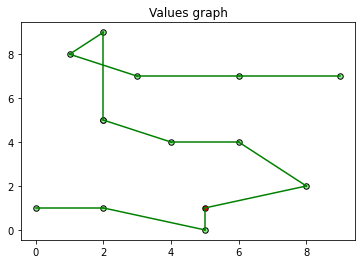

In [19]:
list_x = []
list_y = []

for i in range(len(dots)):
    if i == 10:
        plt.scatter([dots[i][0]],[dots[i][1]],
            marker='o',
            s=30,
            c='red',
            edgecolors='black')
        continue
    list_x.append(dots[i][0])
    list_y.append(dots[i][1])

plt.scatter(list_x,list_y,
           marker='o',
           s=30,
           c='lightgreen',
           edgecolors='black')

plt.title('Values graph')


color_list = ['green','blue','red']
for vehicle_id in range(data['num_vehicles']):

    index = routing.Start(vehicle_id)
    index = solution.Value(routing.NextVar(index))
    previous_index = 0
    pre=dots[0]
    count = 0
    while not routing.IsEnd(index):
        if count == 0:
            pre=dots[index]
            index = solution.Value(routing.NextVar(index))
            previous_index = index
            count+=1
            continue
            
        now = dots[manager.IndexToNode(index)]
        plt.plot([pre[0],now[0]],[pre[1],now[1]],color_list[vehicle_id])
        pre = now
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        if(routing.IsEnd(index)):
            plt.plot([now[0],0],[now[1],1],color=color_list[vehicle_id])


## 